# 決定木による分析

とりあえず、使える特徴はすべて使って決定木に都道府県を分類させてみる。<br>

- 結論<br>
予想通り、座標情報の重要度が大きかったが、思いのほか過マンガン酸カリウム消費や、水温、pHの重要度も大きかった。<br>
座標情報を使わずに分類させてみる必要あり。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../')
%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

## データ読み込み

In [2]:
dataset_path = '../dataset/dbghs/九州/'

In [3]:
list_df = [pd.read_excel(str(p)) for p in Path(dataset_path).glob('*.xls')]
df_kyusyu = pd.concat(list_df)
df_kyusyu.head()

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,採水標高,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,密度,蒸発残留物,電気伝導度,水比抵抗,ＥＨ,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,ＳＯ３２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＰＯ４３−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ Ｈ２Ｓ,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
0,佐賀県,有明町廻里津,130.0,7.0,20.0,33.0,9.0,0.0,NaN,井戸,用水,NaN,NaN,NaN,23.6,NaN,NaN,7.3,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7,NaN,NaN,16.0,4.9,NaN,NaN,0.1,4.6,8.0,NaN,NaN,NaN,NaN,0.06,0.05,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,67.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,0.13,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,佐賀県,白石町,130.0,9.0,0.0,33.0,9.0,40.0,NaN,井戸,用水,NaN,NaN,NaN,20.0,NaN,NaN,7.3,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,NaN,24.9,7.0,NaN,NaN,0.2,4.0,6.8,NaN,NaN,NaN,NaN,0.15,0.00,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.4,NaN,NaN,NaN,NaN,4.4,NaN,NaN,NaN,0.37,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,佐賀県,白石町,130.0,8.0,30.0,33.0,10.0,50.0,NaN,井戸,用水,NaN,NaN,NaN,20.2,NaN,NaN,7.3,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,17.4,5.7,NaN,NaN,0.0,3.6,7.4,NaN,NaN,NaN,NaN,0,0.05,NaN,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,0.14,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,佐賀県,福富町,130.0,11.0,20.0,33.0,11.0,0.0,NaN,井戸,用水,NaN,NaN,NaN,21.6,NaN,Ｈ2Ｓ臭,7.2,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.6,NaN,NaN,259.5,24.9,NaN,NaN,7.0,41.4,49.8,NaN,NaN,NaN,NaN,0.11,0.00,NaN,NaN,NaN,NaN,NaN,NaN,419.1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,297.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.65,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,佐賀県,牛津町,130.0,12.0,0.0,33.0,14.0,20.0,NaN,井戸,用水,151.5,NaN,NaN,19.2,NaN,NaN,7.7,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,26.1,1.7,NaN,NaN,0.3,5.2,18.6,NaN,NaN,NaN,NaN,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,12.1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,113.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.4,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,0.16,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_kyusyu.describe()

,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,採水標高,気温,水温,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,密度,蒸発残留物,電気伝導度,水比抵抗,ＥＨ,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,ＳＯ３２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＰＯ４３−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ Ｈ２Ｓ,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,115.000000,58.000000,662.000000,2152.000000,2167.000000,930.000000,62.000000,553.000000,0.0,1072.000000,158.000000,259.000000,2.000000,430.000000,61.000000,417.000000,1969.000000,1876.000000,110.000000,110.000000,931.000000,1968.000000,1992.000000,102.000000,10.000000,508.000000,1058.000000,213.000000,1217.000000,244.000000,223.000000,155.000000,145.000000,695.000000,2219.000000,482.000000,341.00000,231.000000,282.000000,132.000000,150.000000,171.000000,42.000000,1916.000000,0.0,90.000000,186.000000,0.0,1917.000000,588.000000,256.000000,18.00000,180.000000,22.000000,36.000000,170.000000,42.000000,604.000000,578.000000,453.000000,27.000000,7.000000,415.000000,121.000000,183.000000,121.000000,146.000000,249.000000,119.000000,156.000000,39.000000,255.000000,18.000000,0.0,26.000000,245.000000,478.000000,63.000000
mean,130.052734,29.025391,27.996745,32.087240,28.162760,26.775391,331.700870,-404.672414,20.589728,41.658820,7.184061,7.623484,5.602097,1.002343,NaN,2735.858516,697.937658,5811.621622,-230.000000,9.511093,3.433144,2.001031,707.096823,50.120287,0.268364,0.175545,2.732267,55.930095,94.369566,7.881176,45.650000,5.781339,0.804888,1.912535,2.696725,0.027656,0.144619,0.072000,46.281379,1.972173,1084.995761,9.109400,0.96190,0.834977,0.015004,4.060083,0.650631,15.116825,87.823333,181.633394,NaN,0.538522,0.754737,NaN,320.153991,34.127512,4.001391,0.04150,3.339378,4.228636,0.913333,0.272947,0.046024,87.128084,96.888375,19.294276,3.089630,0.281429,77.567421,273.747107,70.302470,1.440953,0.367671,4.642490,0.246723,224.287897,0.803077,2.304416,1.398333,NaN,7.323077,154.902041,118.882751,4.733333
std,0.764322,16.004275,17.140557,1.226289,17.877858,17.445933,255.485004,178.740564,7.147767,24.917062,1.392366,1.216101,6.921782,0.005208,NaN,5159.575166,1054.015622,3554.386807,14.142136,15.637845,4.668108,4.321481,1459.816556,101.209601,0.325496,0.214624,6.709274,150.806360,226.060094,14.460712,60.718938,30.680399,4.151739,16.731275,11.264828,0.065760,0.391932,0.293307,19.694077,3.052885,2629.518075,12.240993,4.71902,3.305008,0.134236,7.735249,0.802347,188.443456,124.807190,370.362230,NaN,1.382298,2.901323,NaN,481.219619,494.145254,8.522449,0.14917,6.844450,7.747368,1.115580,0.549824,0.051098,92.976160,91.014993,82.945390,2.701173,0.605808,243.218712,359.917690,624.208262,4.708921,0.653186,5.677412,1.151862,487.747728,1.264304,17.406622,2.124015,NaN,10.817405,87.480528,519.294299,14.091258
min,125.000000,0.000000,0.000000,24.000000,0.000000,0.000000,2.700000,-675.000000,-0.500000,2.000000,1.250000,1.700000,0.020000,0.997200,NaN,0.147000,89.300000,200.000000,-240.000000,0.000000,0.000000,0.000000,1.260000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.200000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.010000,0.010000,0.030000,0.000000,NaN,0.000000,0.010000,NaN,0.000000,0.000000,0.001000,0.00100,0.000000,0.100000,0.108000,0.000000,0.000000,0.001000,1.240000,0.000000,0.000000,0.002000,0.000000,18.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,NaN,0.000000,-195.000000,0.000000,0.000000
25%,130.000000,13.000000,12.000000,32.000000,12.000000,10.000000,120.000000,-531.250000,14.925000,20.000000,6.700000,7.400000,0.775000,0.998800,NaN,229.000000,163.125000,3100.000000,-235.000000,0.800000,0.210000,0.050000,21.900000,2.900000,0.052500,0.030000,0.100000,1.700000,8.23

## データ欠損率

データがどれだけ欠損しているか.

まずはgoogleマップAPIと連携を取りたいので座標データが残っているサンプルのみを抽出.

In [5]:
def NA_counter(x_df):
    n_nan = x_df.isnull().sum()
    x_df_dtype = x_df.dtypes
    percent_nan = n_nan/len(x_df)
    return pd.DataFrame([n_nan, percent_nan,x_df_dtype]).rename({0:'n_nan', 1:'%', 2:'dtype'}) 

na_df = NA_counter(df_kyusyu)
na_df

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,採水標高,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,密度,蒸発残留物,電気伝導度,水比抵抗,ＥＨ,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,ＳＯ３２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＰＯ４３−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ Ｈ２Ｓ,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
n_nan,2,786,724,724,724,724,724,724,2145,2,2,1588,2202,1598,108,1649,2233,93,1330,2198,1707,2260,1188,2102,2001,2258,1830,2199,1843,291,384,2150,2150,1329,292,268,2158,2250,1752,1202,1448,2047,1043,2016,2037,2105,2115,1565,41,1778,1919,2029,1978,2128,2110,2089,2218,344,2260,2170,2074,2260,343,1672,2004,2242,2080,2238,2224,2090,2218,1656,1682,1807,2233,2253,1845,2139,2077,2139,2114,2011,1441,220,2,2141,2104,2221,2005,2242,2260,2234,2015,1782,2197
%,0.000884956,0.347788,0.320354,0.320354,0.320354,0.320354,0.320354,0.320354,0.949115,0.000884956,0.000884956,0.702655,0.974336,0.70708,0.0477876,0.729646,0.988053,0.0411504,0.588496,0.972566,0.75531,1,0.525664,0.930088,0.885398,0.999115,0.809735,0.973009,0.815487,0.128761,0.169912,0.951327,0.951327,0.588053,0.129204,0.118584,0.954867,0.995575,0.775221,0.531858,0.640708,0.905752,0.461504,0.892035,0.901327,0.931416,0.935841,0.692478,0.0181416,0.786726,0.849115,0.897788,0.875221,0.941593,0.933628,0.924336,0.981416,0.152212,1,0.960177,0.917699,1,0.15177,0.739823,0.886726,0.992035,0.920354,0.990265,0.984071,0.924779,0.981416,0.732743,0.744248,0.799558,0.988053,0.996903,0.816372,0.94646,0.919027,0.94646,0.935398,0.889823,0.637611,0.0973451,0.000884956,0.947345,0.930973,0.982743,0.887168,0.992035,1,0.988496,0.891593,0.788496,0.972124
dtype,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [6]:
df_kyusyu_grid = df_kyusyu[~pd.isna(df_kyusyu['東経（゜）'])]
df_kyusyu_grid.head(4)

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,採水標高,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,密度,蒸発残留物,電気伝導度,水比抵抗,ＥＨ,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,ＳＯ３２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＰＯ４３−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ Ｈ２Ｓ,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
0,佐賀県,有明町廻里津,130.0,7.0,20.0,33.0,9.0,0.0,NaN,井戸,用水,NaN,NaN,NaN,23.6,NaN,NaN,7.3,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7,NaN,NaN,16.0,4.9,NaN,NaN,0.1,4.6,8.0,NaN,NaN,NaN,NaN,0.06,0.05,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,67.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,0.13,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,佐賀県,白石町,130.0,9.0,0.0,33.0,9.0,40.0,NaN,井戸,用水,NaN,NaN,NaN,20.0,NaN,NaN,7.3,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,NaN,24.9,7.0,NaN,NaN,0.2,4.0,6.8,NaN,NaN,NaN,NaN,0.15,0.00,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.4,NaN,NaN,NaN,NaN,4.4,NaN,NaN,NaN,0.37,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,佐賀県,白石町,130.0,8.0,30.0,33.0,10.0,50.0,NaN,井戸,用水,NaN,NaN,NaN,20.2,NaN,NaN,7.3,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,17.4,5.7,NaN,NaN,0.0,3.6,7.4,NaN,NaN,NaN,NaN,0,0.05,NaN,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,0.14,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,佐賀県,福富町,130.0,11.0,20.0,33.0,11.0,0.0,NaN,井戸,用水,NaN,NaN,NaN,21.6,NaN,Ｈ2Ｓ臭,7.2,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.6,NaN,NaN,259.5,24.9,NaN,NaN,7.0,41.4,49.8,NaN,NaN,NaN,NaN,0.11,0.00,NaN,NaN,NaN,NaN,NaN,NaN,419.1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,297.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.65,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_kyusyu_grid.describe()

,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,採水標高,気温,水温,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,密度,蒸発残留物,電気伝導度,水比抵抗,ＥＨ,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,ＳＯ３２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＰＯ４３−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ Ｈ２Ｓ,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,115.000000,0.0,566.000000,1492.000000,1513.000000,601.000000,62.000000,543.000000,0.0,809.000000,80.000000,47.000000,0.0,277.000000,58.000000,332.000000,1454.000000,1452.000000,110.000000,110.000000,780.000000,1445.000000,1466.000000,102.000000,10.000000,494.000000,892.000000,116.000000,1019.000000,244.000000,223.000000,155.000000,145.000000,684.000000,1520.000000,457.000000,314.000000,225.000000,209.000000,80.000000,150.000000,171.000000,42.000000,1396.000000,0.0,90.000000,186.000000,0.0,1379.000000,470.000000,256.000000,18.00000,172.000000,22.000000,36.000000,170.000000,42.000000,485.000000,578.000000,389.000000,22.000000,1.000,325.000000,55.000000,183.000000,121.000000,104.000000,249.000000,110.000000,122.000000,7.000000,254.000000,18.000000,0.0,26.000000,37.000000,276.000000,60.000000
mean,130.052734,29.025391,27.996745,32.087240,28.162760,26.775391,331.700870,NaN,21.120495,43.792225,7.270615,7.483045,5.602097,1.002381,NaN,3422.695413,507.551875,4847.446809,NaN,6.925668,3.610534,1.858795,815.971324,56.876337,0.268364,0.175545,2.561059,66.516329,109.227128,7.881176,45.650000,5.683354,0.821351,3.113621,3.106765,0.027656,0.144619,0.072000,46.281379,1.988918,1310.670207,8.884337,1.042306,0.853660,0.019713,4.350400,0.650631,15.116825,87.823333,207.753788,NaN,0.538522,0.754737,NaN,330.780371,38.861051,4.001391,0.04150,3.390023,4.228636,0.913333,0.272947,0.046024,101.160540,96.888375,15.683087,2.390909,0.251,84.704006,287.612727,70.302470,1.440953,0.160817,4.642490,0.120545,276.426230,1.167143,2.313488,1.398333,NaN,7.323077,90.297297,172.286214,4.970000
std,0.764322,16.004275,17.140557,1.226289,17.877858,17.445933,255.485004,NaN,7.265742,23.915182,1.418996,1.448070,6.921782,0.005244,NaN,5685.305665,715.530518,3229.878493,NaN,12.805094,4.720919,3.857300,1596.306490,107.274598,0.325496,0.214624,6.357027,170.868054,254.902914,14.460712,60.718938,30.702968,4.035755,22.532428,12.258051,0.065760,0.391932,0.293307,19.694077,3.066988,2945.793464,12.336502,4.910005,3.346933,0.155720,8.342521,0.802347,188.443456,124.807190,402.916962,NaN,1.382298,2.901323,NaN,498.981129,552.599476,8.522449,0.14917,6.950604,7.747368,1.115580,0.549824,0.051098,95.692539,91.014993,26.343857,2.489821,NaN,269.127259,349.602017,624.208262,4.708921,0.201273,5.677412,0.462900,539.402411,2.244005,17.440384,2.124015,NaN,10.817405,125.355243,676.468848,14.403605
min,125.000000,0.000000,0.000000,24.000000,0.000000,0.000000,2.700000,NaN,-0.500000,6.900000,1.600000,1.700000,0.020000,0.997200,NaN,0.147000,89.300000,200.000000,NaN,0.000000,0.000000,0.000000,1.260000,0.124000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.200000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.030000,0.000000,NaN,0.000000,0.010000,NaN,0.000000,0.000000,0.001000,0.00100,0.000000,0.100000,0.108000,0.000000,0.000000,1.330000,1.240000,0.000000,0.000000,0.251,0.000000,22.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,NaN,0.000000,-195.000000,0.000000,0.000000
25%,130.000000,13.000000,12.000000,32.000000,12.000000,10.000000,120.000000,NaN,15.225000,21.600000,6.800000,7.300000,0.775000,0.998800,NaN,324.500000,129.375000,2900.000000,NaN,0.610000,0.405750,0.070000,40.200000,3.095000,0.052500,0.030000,0.100000,1.200000,8.167000,0.300000,0.150000,0.060000,0.030000,0.000000,0.080000,0.000000,0.010000,0.010000,33.

## いらない特徴を再度消す

再度、欠損値を見てみる

In [8]:
na_df = NA_counter(df_kyusyu_grid)
na_df

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,採水標高,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,密度,蒸発残留物,電気伝導度,水比抵抗,ＥＨ,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,ＳＯ３２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＰＯ４３−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ Ｈ２Ｓ,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
n_nan,0,724,0,0,0,0,0,0,1421,0,0,1143,1536,970,44,1044,1519,23,935,1474,993,1536,727,1456,1489,1536,1259,1478,1204,82,84,1426,1426,756,91,70,1434,1526,1042,644,990,1420,517,1292,1313,1381,1391,852,16,1079,1222,1311,1327,1456,1386,1365,1494,140,1536,1446,1350,1536,157,1066,1280,1518,1364,1514,1500,1366,1494,1051,958,1147,1514,1535,1211,1481,1353,1415,1432,1287,790,94,0,1426,1414,1529,1282,1518,1536,1510,1499,1260,1476
%,0,0.471354,0,0,0,0,0,0,0.92513,0,0,0.744141,1,0.63151,0.0286458,0.679688,0.988932,0.014974,0.608724,0.959635,0.646484,1,0.473307,0.947917,0.969401,1,0.819661,0.96224,0.783854,0.0533854,0.0546875,0.928385,0.928385,0.492188,0.0592448,0.0455729,0.933594,0.99349,0.678385,0.419271,0.644531,0.924479,0.336589,0.841146,0.854818,0.899089,0.905599,0.554688,0.0104167,0.702474,0.795573,0.853516,0.863932,0.947917,0.902344,0.888672,0.972656,0.0911458,1,0.941406,0.878906,1,0.102214,0.69401,0.833333,0.988281,0.888021,0.985677,0.976562,0.889323,0.972656,0.684245,0.623698,0.746745,0.985677,0.999349,0.788411,0.964193,0.880859,0.921224,0.932292,0.837891,0.514323,0.0611979,0,0.928385,0.920573,0.995443,0.834635,0.988281,1,0.983073,0.975911,0.820312,0.960938
dtype,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


全部欠損値のカラムがある

## そもそもすべてが欠損値のカラムは消してしまう

In [9]:
na_col_names = df_kyusyu_grid.columns[na_df.loc['%'] == 1] # drop n_nan rate 100% columns
df_kyusyu_grid = df_kyusyu_grid.drop(na_col_names, axis=1)
df_kyusyu_grid.head()

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
0,佐賀県,有明町廻里津,130.0,7.0,20.0,33.0,9.0,0.0,NaN,井戸,用水,NaN,NaN,23.6,NaN,NaN,7.3,7.5,NaN,NaN,NaN,NaN,NaN,3.7,NaN,NaN,16.0,4.9,NaN,NaN,0.1,4.6,8.0,NaN,NaN,NaN,NaN,0.06,0.05,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,67.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,0.13,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,佐賀県,白石町,130.0,9.0,0.0,33.0,9.0,40.0,NaN,井戸,用水,NaN,NaN,20.0,NaN,NaN,7.3,7.4,NaN,NaN,NaN,NaN,NaN,3.8,NaN,NaN,24.9,7.0,NaN,NaN,0.2,4.0,6.8,NaN,NaN,NaN,NaN,0.15,0.00,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.4,NaN,NaN,NaN,NaN,4.4,NaN,NaN,NaN,0.37,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,佐賀県,白石町,130.0,8.0,30.0,33.0,10.0,50.0,NaN,井戸,用水,NaN,NaN,20.2,NaN,NaN,7.3,7.3,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,17.4,5.7,NaN,NaN,0.0,3.6,7.4,NaN,NaN,NaN,NaN,0,0.05,NaN,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,0.14,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,佐賀県,福富町,130.0,11.0,20.0,33.0,11.0,0.0,NaN,井戸,用水,NaN,NaN,21.6,NaN,Ｈ2Ｓ臭,7.2,7.7,NaN,NaN,NaN,NaN,NaN,24.6,NaN,NaN,259.5,24.9,NaN,NaN,7.0,41.4,49.8,NaN,NaN,NaN,NaN,0.11,0.00,NaN,NaN,NaN,NaN,NaN,NaN,419.1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,297.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.65,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,佐賀県,牛津町,130.0,12.0,0.0,33.0,14.0,20.0,NaN,井戸,用水,151.5,NaN,19.2,NaN,NaN,7.7,7.7,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,26.1,1.7,NaN,NaN,0.3,5.2,18.6,NaN,NaN,NaN,NaN,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,12.1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,113.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.4,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,0.16,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
NA_counter(df_kyusyu_grid)

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
n_nan,0,724,0,0,0,0,0,0,1421,0,0,1143,970,44,1044,1519,23,935,1474,993,727,1456,1489,1259,1478,1204,82,84,1426,1426,756,91,70,1434,1526,1042,644,990,1420,517,1292,1313,1381,1391,852,16,1079,1222,1311,1327,1456,1386,1365,1494,140,1446,1350,157,1066,1280,1518,1364,1514,1500,1366,1494,1051,958,1147,1514,1535,1211,1481,1353,1415,1432,1287,790,94,0,1426,1414,1529,1282,1518,1510,1499,1260,1476
%,0,0.471354,0,0,0,0,0,0,0.92513,0,0,0.744141,0.63151,0.0286458,0.679688,0.988932,0.014974,0.608724,0.959635,0.646484,0.473307,0.947917,0.969401,0.819661,0.96224,0.783854,0.0533854,0.0546875,0.928385,0.928385,0.492188,0.0592448,0.0455729,0.933594,0.99349,0.678385,0.419271,0.644531,0.924479,0.336589,0.841146,0.854818,0.899089,0.905599,0.554688,0.0104167,0.702474,0.795573,0.853516,0.863932,0.947917,0.902344,0.888672,0.972656,0.0911458,0.941406,0.878906,0.102214,0.69401,0.833333,0.988281,0.888021,0.985677,0.976562,0.889323,0.972656,0.684245,0.623698,0.746745,0.985677,0.999349,0.788411,0.964193,0.880859,0.921224,0.932292,0.837891,0.514323,0.0611979,0,0.928385,0.920573,0.995443,0.834635,0.988281,0.983073,0.975911,0.820312,0.960938
dtype,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64


## イオン濃度の欠損値には0埋めする

イオン濃度が欠損しているということは、その温泉の売り成分ではないと考えられるため

In [11]:
iron_names = df_kyusyu_grid.iloc[:, 24:-12].columns
iron_names_replace_0 = {str(n):0 for n in iron_names}
df_kyusyu_grid = df_kyusyu_grid.fillna(iron_names_replace_0)

In [12]:
df_kyusyu_grid.head()

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
0,佐賀県,有明町廻里津,130.0,7.0,20.0,33.0,9.0,0.0,NaN,井戸,用水,NaN,NaN,23.6,NaN,NaN,7.3,7.5,NaN,NaN,NaN,NaN,NaN,3.7,0.0,0.0,16.0,4.9,0.0,0.0,0.1,4.6,8.0,0.0,0.0,0.0,0.0,0.06,0.05,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,67.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.6,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.13,0.0,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,佐賀県,白石町,130.0,9.0,0.0,33.0,9.0,40.0,NaN,井戸,用水,NaN,NaN,20.0,NaN,NaN,7.3,7.4,NaN,NaN,NaN,NaN,NaN,3.8,0.0,0.0,24.9,7.0,0.0,0.0,0.2,4.0,6.8,0.0,0.0,0.0,0.0,0.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.4,0.0,0.0,0.0,0.0,4.4,0.0,0.0,0.0,0.37,0.0,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,佐賀県,白石町,130.0,8.0,30.0,33.0,10.0,50.0,NaN,井戸,用水,NaN,NaN,20.2,NaN,NaN,7.3,7.3,NaN,NaN,NaN,NaN,NaN,0.4,0.0,0.0,17.4,5.7,0.0,0.0,0.0,3.6,7.4,0.0,0.0,0.0,0.0,0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,10.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.6,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.14,0.0,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,佐賀県,福富町,130.0,11.0,20.0,33.0,11.0,0.0,NaN,井戸,用水,NaN,NaN,21.6,NaN,Ｈ2Ｓ臭,7.2,7.7,NaN,NaN,NaN,NaN,NaN,24.6,0.0,0.0,259.5,24.9,0.0,0.0,7.0,41.4,49.8,0.0,0.0,0.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,419.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,297.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65,0.0,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,佐賀県,牛津町,130.0,12.0,0.0,33.0,14.0,20.0,NaN,井戸,用水,151.5,NaN,19.2,NaN,NaN,7.7,7.7,NaN,NaN,NaN,NaN,NaN,1.7,0.0,0.0,26.1,1.7,0.0,0.0,0.3,5.2,18.6,0.0,0.0,0.0,0.0,0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,12.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.4,0.0,0.0,0.0,0.0,1.7,0.0,0.0,0.0,0.16,0.0,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## イオンの欠損値を0埋めしたところで、ほかの欠損値も確認

In [13]:
NA_counter(df_kyusyu_grid)

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
n_nan,0,724,0,0,0,0,0,0,1421,0,0,1143,970,44,1044,1519,23,935,1474,993,727,1456,1489,1259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,790,94,0,1426,1414,1529,1282,1518,1510,1499,1260,1476
%,0,0.471354,0,0,0,0,0,0,0.92513,0,0,0.744141,0.63151,0.0286458,0.679688,0.988932,0.014974,0.608724,0.959635,0.646484,0.473307,0.947917,0.969401,0.819661,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.514323,0.0611979,0,0.928385,0.920573,0.995443,0.834635,0.988281,0.983073,0.975911,0.820312,0.960938
dtype,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64


標高・井戸深度・気温・水質：欠損が多いし重要じゃなさそうなので消してヨシ！<br>
イオン濃度と相関がありそうな比重・電気伝導度・水比抵抗・KMnO4消費も消す.<br>
よく分からんのがRpH, Rn, 蒸発残留物, free H2s以降. この辺は9割欠損しているので無くてもいいような気はする.<br>
free H2Sが3つあるのもよく分からん. イオン以降はすべて消してもいいかもしれん.<br>

とりあえず可能な限りdropしてみる.

In [14]:
df_kyusyu_grid = df_kyusyu_grid.iloc[:, :-12]
df_kyusyu_grid.head()

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ
0,佐賀県,有明町廻里津,130.0,7.0,20.0,33.0,9.0,0.0,NaN,井戸,用水,NaN,NaN,23.6,NaN,NaN,7.3,7.5,NaN,NaN,NaN,NaN,NaN,3.7,0.0,0.0,16.0,4.9,0.0,0.0,0.1,4.6,8.0,0.0,0.0,0.0,0.0,0.06,0.05,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,67.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.6,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.13,0.0
1,佐賀県,白石町,130.0,9.0,0.0,33.0,9.0,40.0,NaN,井戸,用水,NaN,NaN,20.0,NaN,NaN,7.3,7.4,NaN,NaN,NaN,NaN,NaN,3.8,0.0,0.0,24.9,7.0,0.0,0.0,0.2,4.0,6.8,0.0,0.0,0.0,0.0,0.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.4,0.0,0.0,0.0,0.0,4.4,0.0,0.0,0.0,0.37,0.0
2,佐賀県,白石町,130.0,8.0,30.0,33.0,10.0,50.0,NaN,井戸,用水,NaN,NaN,20.2,NaN,NaN,7.3,7.3,NaN,NaN,NaN,NaN,NaN,0.4,0.0,0.0,17.4,5.7,0.0,0.0,0.0,3.6,7.4,0.0,0.0,0.0,0.0,0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,10.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.6,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.14,0.0
3,佐賀県,福富町,130.0,11.0,20.0,33.0,11.0,0.0,NaN,井戸,用水,NaN,NaN,21.6,NaN,Ｈ2Ｓ臭,7.2,7.7,NaN,NaN,NaN,NaN,NaN,24.6,0.0,0.0,259.5,24.9,0.0,0.0,7.0,41.4,49.8,0.0,0.0,0.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,419.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,297.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65,0.0
4,佐賀県,牛津町,130.0,12.0,0.0,33.0,14.0,20.0,NaN,井戸,用水,151.5,NaN,19.2,NaN,NaN,7.7,7.7,NaN,NaN,NaN,NaN,NaN,1.7,0.0,0.0,26.1,1.7,0.0,0.0,0.3,5.2,18.6,0.0,0.0,0.0,0.0,0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,12.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.4,0.0,0.0,0.0,0.0,1.7,0.0,0.0,0.0,0.16,0.0


In [15]:
df_kyusyu_grid = df_kyusyu_grid.drop(columns=['標高（ｍ）', '井戸深度', '気温', '水質（外観臭味）'])
df_kyusyu_grid.head()

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),水源種別,利用目的,水温,湧出量,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ
0,佐賀県,有明町廻里津,130.0,7.0,20.0,33.0,9.0,0.0,井戸,用水,23.6,NaN,7.3,7.5,NaN,NaN,NaN,NaN,NaN,3.7,0.0,0.0,16.0,4.9,0.0,0.0,0.1,4.6,8.0,0.0,0.0,0.0,0.0,0.06,0.05,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,67.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.6,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.13,0.0
1,佐賀県,白石町,130.0,9.0,0.0,33.0,9.0,40.0,井戸,用水,20.0,NaN,7.3,7.4,NaN,NaN,NaN,NaN,NaN,3.8,0.0,0.0,24.9,7.0,0.0,0.0,0.2,4.0,6.8,0.0,0.0,0.0,0.0,0.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.4,0.0,0.0,0.0,0.0,4.4,0.0,0.0,0.0,0.37,0.0
2,佐賀県,白石町,130.0,8.0,30.0,33.0,10.0,50.0,井戸,用水,20.2,NaN,7.3,7.3,NaN,NaN,NaN,NaN,NaN,0.4,0.0,0.0,17.4,5.7,0.0,0.0,0.0,3.6,7.4,0.0,0.0,0.0,0.0,0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,10.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.6,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.14,0.0
3,佐賀県,福富町,130.0,11.0,20.0,33.0,11.0,0.0,井戸,用水,21.6,NaN,7.2,7.7,NaN,NaN,NaN,NaN,NaN,24.6,0.0,0.0,259.5,24.9,0.0,0.0,7.0,41.4,49.8,0.0,0.0,0.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,419.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,297.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65,0.0
4,佐賀県,牛津町,130.0,12.0,0.0,33.0,14.0,20.0,井戸,用水,19.2,NaN,7.7,7.7,NaN,NaN,NaN,NaN,NaN,1.7,0.0,0.0,26.1,1.7,0.0,0.0,0.3,5.2,18.6,0.0,0.0,0.0,0.0,0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,12.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.4,0.0,0.0,0.0,0.0,1.7,0.0,0.0,0.0,0.16,0.0


In [16]:
NA_counter(df_kyusyu_grid)

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),水源種別,利用目的,水温,湧出量,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ
n_nan,0,724,0,0,0,0,0,0,0,0,44,1044,23,935,1474,993,727,1456,1489,1259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
%,0,0.471354,0,0,0,0,0,0,0,0,0.0286458,0.679688,0.014974,0.608724,0.959635,0.646484,0.473307,0.947917,0.969401,0.819661,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dtype,object,object,float64,float64,float64,float64,float64,float64,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## object型を含むサンプルの確認

In [17]:
#for i, d in enumerate(df_kyusyu_grid['湧出量']):
#    if not isinstance(d, (int, float)):
#        df_kyusyu_grid = df_kyusyu_grid.drop(index=i)

for _col_name in df_kyusyu_grid.columns:
    d_col = df_kyusyu_grid[_col_name]
    if d_col.dtype == 'object':
        print(_col_name)

都道府県名
所在地
水源種別
利用目的
湧出量
Ｆｅ２＋


## 使えるobject変数はダミー変数へ変換

In [18]:
dummy_df = pd.get_dummies(df_kyusyu_grid[['所在地','水源種別', '利用目的']])
df_kyusyu_grid = pd.merge(df_kyusyu_grid, dummy_df, right_index=True, left_index=True)
df_kyusyu_grid = df_kyusyu_grid.drop(['所在地','水源種別', '利用目的'],axis=1)
df_kyusyu_grid.head()

,都道府県名,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),水温,湧出量,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,所在地_Kurinotake,所在地_えびの市下水流,所在地_えびの市亀沢,所在地_えびの市内堅,所在地_えびの市向江,所在地_えびの市岡松,所在地_えびの市昌明寺,所在地_えびの市末永,所在地_えびの市末永字白鳥,所在地_えびの市水流,所在地_えびの市永山,所在地_ラムネ,所在地_三井郡,所在地_三井郡上高橋,所在地_三井郡二森,所在地_三井郡八坂,所在地_三井郡北野,所在地_三井郡大城,所在地_三井郡守部,所在地_三根町,所在地_三根町三根中学校,所在地_三田川町役場,所在地_上益城郡喜島村,所在地_下ル町,所在地_下川尻町,所在地_下益城郡,所在地_下益城郡富合,所在地_与那原町上与那原,所在地_与那原町当添,所在地_与那城村屋慶名,所在地_中津市,所在地_久留米市,所在地_久留米市八丁島,所在地_久留米市大杜,所在地_九重町湯坪,所在地_九重町田野,所在地_九重町田野筌ノ口,所在地_九重町町田,所在地_九重町菅原,所在地_二日市,所在地_二日市町,所在地_佐々町,所在地_佐世保市,所在地_佐賀市,所在地_佐賀市久保田町,所在地_佐賀市北川副町,所在地_佐賀市喜瀬新町,所在地_佐賀市諸富町,所在地_佐賀市高木勢町,所在地_八代市三ツ江湖町,所在地_八代市三楽町,所在地_八代市十条町,所在地_八代市千丁町古閑出,所在地_八代市南平和町,所在地_八代市古閑下町,所在地_八代市古閑中町,所在地_八代市古閑浜町,所在地_八代市大福町,所在地_八代市日奈久新開町,所在地_八代市昭和明徴町,所在地_八代市本野町,所在地_八代市松江城町,所在地_八代市水島町,所在地_八代市永てい町,所在地_八代市興国町,所在地_八代市迎町（市立三中）,所在地_八代市郡築十二番町,所在地_八代市高植本町,所在地_具志川村平良川,所在地_別府市上人ヶ浜町,所在地_別府市上原町,所在地_別府市中河原,所在地_別府市乙原,所在地_別府市亀川中央,所在地_別府市北中町,所在地_別府市南立石,所在地_別府市堀田,所在地_別府市大字野田,所在地_別府市大字鉄輪,所在地_別府市大字鶴見字三月田,所在地_別府市大字鶴見字小倉,所在地_別府市天満,所在地_別府市山王,所在地_別府市明礬,所在地_別府市松原町,所在地_別府市照波園町,所在地_別府市竹の内,所在地_別府市観海寺,所在地_別府市鉄輪井田,所在地_別府市鉄輪御幸,所在地_別府市鉄輪東,所在地_別府市鉄輪風呂本,所在地_別府市馬場水車,所在地_加津佐町,所在地_勝本町,所在地_北本町,所在地_北町,所在地_北茂安町町営住宅,所在地_北野町,所在地_千々石町,所在地_千代田町,所在地_千代田町給食センタ−,所在地_千年,所在地_協和町,所在地_南小国町満願寺,所在地_南小国町満願寺北黒川,所在地_南小国町満願寺小東瀬,所在地_南小国町満願寺田の原,所在地_南小国町満願寺西黒川,所在地_南小国町満願寺黒川,所在地_南有馬町,所在地_南本町,所在地_南風原村津嘉山区,所在地_南風原町津嘉山,所在地_口之津町,所在地_古川,所在地_古湯温泉,所在地_吉松地区,所在地_名護町東江,所在地_向町,所在地_吾妻町,所在地_嘉手納村屋良,所在地_塩浸,所在地_外海町,所在地_多良見町,所在地_大久保町,所在地_大分市,所在地_大分市下八幡６組,所在地_大分市古国分字花園,所在地_大分市国分,所在地_大分市豊町,所在地_大分市賀来大字中河原,所在地_大分郡床内町西長宝字岩下,所在地_大分郡挾間町挾間,所在地_大分郡挾間町赤野,所在地_大分郡挾間町鬼崎,所在地_大分郡挾間町鬼須字池の上,所在地_大分郡湯布院町大字塚原,所在地_大分郡湯布院町大字川上,所在地_大分郡湯布院町大字川上湯の坪,所在地_大分郡湯布院町大字川北,所在地_大分郡湯布院町大字川南,所在地_大分郡湯布院町大字川南字中の切,所在地_大分郡湯布院町大字川南字東石松,所在地_大分郡湯布院町大字川南字田中市,所在地_大分郡湯布院町大字川南字石松,所在地_大分郡湯布院町大字湯平,所在地_大分郡湯布院町湯平字花合野,所在地_大和町,所在地_大塔町,所在地_大宮町,所在地_大島村,所在地_大川市,所在地_大村市,所在地_天瀬町桜竹,所在地_天瀬町湯山,所在地_天瀬町湯釣,所在地_天瀬町赤岩,所在地_奈良尾町,所在地_宇佐郡安心院町大字下毛字新貝,所在地_宇佐郡安心院町大字六郎丸,所在地_宇佐郡長州町,所在地_宇土郡宇土,所在地_宮古島下地町上地,所在地_宮古島城辺町砂川,所在地_富川町,所在地_富江町,所在地_小国町北里奴留湯,所在地_小国町北里山川,所在地_小国町大字下城,所在地_小国町西里はげの湯,所在地_小林地区,所在地_小林市堤,所在地_小浜町,所在地_山の湯,所在地_山ノ上戸,所在地_山口旅館,所在地_山川温泉（成川海岸）,所在地_山川温泉（日本冷蔵会社）,所在地_山川温泉（田村館）,所在地_山香町,所在地_岡児ケ水,所在地_岱明村,所在地_島原半島,所在地_崎岡町,所在地_川副町,所在地_川尻温泉,所在地_川尻町,所在地_川棚町,所在地_広田町,所在地_広馬場町,所在地_庄内町,所在地_庄内町大字中原,所在地_庄内町大字大竜字松の本,所在地_庄内町大字畑田字天神山,所在地_庄内町大字西長宝字上屋敷,所在地_庄内町大字高岡橋爪,所在地_庄内町東長宝字榎ツル,所在地_志佐町,所在地_志折郷,所在地_志波・原鶴,所在地_愛野町,所在地_挾間町,所在地_新湯,所在地_新行江町,所在地_新魚目町,所在地_早苗町,所在地_春日町,所在地_時津町,所在地_有明町,所在地_有明町廻里津,所在地_朝倉郡立出,所在地_朝倉郡長渕,所在地_本山町,所在地_東与賀町,所在地_東彼杵町,所在地_杷木町,所在地_松原町,所在地_松里町,所在地_林田,所在地_柳川市,所在地_桑木場町,所在地_森山村,所在地_横島村,所在地_江の浦町,所在地_沖永良部島,所在地_沖縄本島南部地区喜屋武,所在地_波佐見町,所在地_浜児ケ水,所在地_浮羽町,所在地_浮羽郡田主丸,所在地_浮羽郡菅原,所在地_深江町,所在地_湊町,所在地_湯布院町大字湯平字前田,所在地_湯布院町大字湯平字屋敷,所在地_湯布院町大字湯平字栗谷,所在地_湯布院町大字湯平字谷向,所在地_熊ノ川温泉,所在地_熊本市,所在地_熊本市上熊本花園町,所在地_熊本市健軍町,所在地_熊本市八景水谷,所在地_熊本市内坪井町,所在地_熊本市出水町,所在地_熊本市北新坪井町,所在地_熊本市南高江町,所在地_熊本市大江町,所在地_熊本市島崎町,所在地_熊本市川尻,所在地_熊本市川尻南高江,所在地_熊本市川尻町,所在地_熊本市春日町,所在地_熊本市春竹町,所在地_熊本市本山町,所在地_熊本市東町,所在地_熊本市池田町,所在地_熊本市田崎町,所在地_熊本市花園町,所在地_牛津町,所在地_玄海町,所在地_玄海町温泉,所在地_玉名市,所在地_玖珠郡九重町大字野上,所在地_甘木市倉吉,所在地_甘木市千代丸,所在地_甘木市本上浦,所在地_甘木市林田,所在地_甘木市牛鶴,所在地_田下町,所在地_田島,所在地_白石町,所在地_益城町,所在地_直入町長湯,所在地_直入町長湯山脇,所在地_直入町長湯栃原,所在地_相知温泉,所在地_知念村知念岬,所在地_石川市伊波,所在地_神崎市,所在地_神崎温泉,所在地_神崎町神崎小学校,所在地_福富町,所在地_穂波村,所在地_立石南触,所在地_立石西触,所在地_筑紫野町,所在地_筑邦町,所在地_美里村知花,所在地_耶馬渓町深耶馬,所在地_耶馬渓町深耶馬渓字深瀬,所在地_芦辺町,所在地_行橋市,所在地_袖木町,所在地_西原村与那城,所在地_西原村嘉手苅,所在地_西有家町,所在地_西海町,所在地_西諸県郡高原町蒲牟田,所在地_西諸県郡高原町西麓,所在地_託麻村,所在地_諌早市,所在地_諫早市,所在地_諸富町,所在地_豊前市,所在地_豊後高田市,所在地_豊後高田市玉津志手町１３５０,所在地_豊肥地域,所在地_豊肥地域串野,所在地_豊肥地域八丁原,所在地_豊肥地域吉部,所在地_豊肥地域大将軍谷,所在地_豊肥地域大岳,所在地_豊肥地域奴留湯,所在地_豊肥地域宝泉寺,所在地_豊肥地域寒ノ地獄,所在地_豊肥地域寺尾野,所在地_豊肥地域小田,所在地_豊肥地域山,所在地_豊肥地域岳湯,所在地_豊肥地域川底,所在地_豊肥地域河原湯,所在地_豊肥地域湯坪,所在地_豊肥地域満願寺,所在地_豊肥地域牧ノ戸,所在地_豊肥地域生滝,所在地_豊肥地域田の原,所在地_豊肥地域疥癬湯,所在地_豊肥地域筋湯,所在地_豊肥地域筌ノ口,所在地_豊肥地域雀の地獄,所在地_豊肥地域黒川,

In [19]:
import category_encoders as ce

# Eoncodeしたい列をリストで指定。もちろん複数指定可能。
list_cols = ['都道府県名']

#target_names_and_label = [
#    {
#        'col':'都道府県名',
#        'mapping':[
#            ('福岡県', 0),
#            ('佐賀県', 1),
#            ('長崎県', 2),
#            ('熊本県', 3),
#            ('大分県', 4),
#            ('宮崎県', 5),
#            ('鹿児島県',6),
#            ('沖縄県', 7)]
#    },
#]

# 序数をカテゴリに付与して変換
#ce_oe = ce.OrdinalEncoder(cols=list_cols, handle_unknown='impute', mapping=target_names_and_label)
ce_oe = ce.OrdinalEncoder(cols=list_cols, handle_unknown='impute')
df_kyusyu_grid = ce_oe.fit_transform(df_kyusyu_grid)

df_kyusyu_grid.head()
#df_kyusyu_grid = df_kyusyu_grid.drop(['都道府県名'],axis=1)
#df_kyusyu_grid.head()

,都道府県名,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),水温,湧出量,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,所在地_Kurinotake,所在地_えびの市下水流,所在地_えびの市亀沢,所在地_えびの市内堅,所在地_えびの市向江,所在地_えびの市岡松,所在地_えびの市昌明寺,所在地_えびの市末永,所在地_えびの市末永字白鳥,所在地_えびの市水流,所在地_えびの市永山,所在地_ラムネ,所在地_三井郡,所在地_三井郡上高橋,所在地_三井郡二森,所在地_三井郡八坂,所在地_三井郡北野,所在地_三井郡大城,所在地_三井郡守部,所在地_三根町,所在地_三根町三根中学校,所在地_三田川町役場,所在地_上益城郡喜島村,所在地_下ル町,所在地_下川尻町,所在地_下益城郡,所在地_下益城郡富合,所在地_与那原町上与那原,所在地_与那原町当添,所在地_与那城村屋慶名,所在地_中津市,所在地_久留米市,所在地_久留米市八丁島,所在地_久留米市大杜,所在地_九重町湯坪,所在地_九重町田野,所在地_九重町田野筌ノ口,所在地_九重町町田,所在地_九重町菅原,所在地_二日市,所在地_二日市町,所在地_佐々町,所在地_佐世保市,所在地_佐賀市,所在地_佐賀市久保田町,所在地_佐賀市北川副町,所在地_佐賀市喜瀬新町,所在地_佐賀市諸富町,所在地_佐賀市高木勢町,所在地_八代市三ツ江湖町,所在地_八代市三楽町,所在地_八代市十条町,所在地_八代市千丁町古閑出,所在地_八代市南平和町,所在地_八代市古閑下町,所在地_八代市古閑中町,所在地_八代市古閑浜町,所在地_八代市大福町,所在地_八代市日奈久新開町,所在地_八代市昭和明徴町,所在地_八代市本野町,所在地_八代市松江城町,所在地_八代市水島町,所在地_八代市永てい町,所在地_八代市興国町,所在地_八代市迎町（市立三中）,所在地_八代市郡築十二番町,所在地_八代市高植本町,所在地_具志川村平良川,所在地_別府市上人ヶ浜町,所在地_別府市上原町,所在地_別府市中河原,所在地_別府市乙原,所在地_別府市亀川中央,所在地_別府市北中町,所在地_別府市南立石,所在地_別府市堀田,所在地_別府市大字野田,所在地_別府市大字鉄輪,所在地_別府市大字鶴見字三月田,所在地_別府市大字鶴見字小倉,所在地_別府市天満,所在地_別府市山王,所在地_別府市明礬,所在地_別府市松原町,所在地_別府市照波園町,所在地_別府市竹の内,所在地_別府市観海寺,所在地_別府市鉄輪井田,所在地_別府市鉄輪御幸,所在地_別府市鉄輪東,所在地_別府市鉄輪風呂本,所在地_別府市馬場水車,所在地_加津佐町,所在地_勝本町,所在地_北本町,所在地_北町,所在地_北茂安町町営住宅,所在地_北野町,所在地_千々石町,所在地_千代田町,所在地_千代田町給食センタ−,所在地_千年,所在地_協和町,所在地_南小国町満願寺,所在地_南小国町満願寺北黒川,所在地_南小国町満願寺小東瀬,所在地_南小国町満願寺田の原,所在地_南小国町満願寺西黒川,所在地_南小国町満願寺黒川,所在地_南有馬町,所在地_南本町,所在地_南風原村津嘉山区,所在地_南風原町津嘉山,所在地_口之津町,所在地_古川,所在地_古湯温泉,所在地_吉松地区,所在地_名護町東江,所在地_向町,所在地_吾妻町,所在地_嘉手納村屋良,所在地_塩浸,所在地_外海町,所在地_多良見町,所在地_大久保町,所在地_大分市,所在地_大分市下八幡６組,所在地_大分市古国分字花園,所在地_大分市国分,所在地_大分市豊町,所在地_大分市賀来大字中河原,所在地_大分郡床内町西長宝字岩下,所在地_大分郡挾間町挾間,所在地_大分郡挾間町赤野,所在地_大分郡挾間町鬼崎,所在地_大分郡挾間町鬼須字池の上,所在地_大分郡湯布院町大字塚原,所在地_大分郡湯布院町大字川上,所在地_大分郡湯布院町大字川上湯の坪,所在地_大分郡湯布院町大字川北,所在地_大分郡湯布院町大字川南,所在地_大分郡湯布院町大字川南字中の切,所在地_大分郡湯布院町大字川南字東石松,所在地_大分郡湯布院町大字川南字田中市,所在地_大分郡湯布院町大字川南字石松,所在地_大分郡湯布院町大字湯平,所在地_大分郡湯布院町湯平字花合野,所在地_大和町,所在地_大塔町,所在地_大宮町,所在地_大島村,所在地_大川市,所在地_大村市,所在地_天瀬町桜竹,所在地_天瀬町湯山,所在地_天瀬町湯釣,所在地_天瀬町赤岩,所在地_奈良尾町,所在地_宇佐郡安心院町大字下毛字新貝,所在地_宇佐郡安心院町大字六郎丸,所在地_宇佐郡長州町,所在地_宇土郡宇土,所在地_宮古島下地町上地,所在地_宮古島城辺町砂川,所在地_富川町,所在地_富江町,所在地_小国町北里奴留湯,所在地_小国町北里山川,所在地_小国町大字下城,所在地_小国町西里はげの湯,所在地_小林地区,所在地_小林市堤,所在地_小浜町,所在地_山の湯,所在地_山ノ上戸,所在地_山口旅館,所在地_山川温泉（成川海岸）,所在地_山川温泉（日本冷蔵会社）,所在地_山川温泉（田村館）,所在地_山香町,所在地_岡児ケ水,所在地_岱明村,所在地_島原半島,所在地_崎岡町,所在地_川副町,所在地_川尻温泉,所在地_川尻町,所在地_川棚町,所在地_広田町,所在地_広馬場町,所在地_庄内町,所在地_庄内町大字中原,所在地_庄内町大字大竜字松の本,所在地_庄内町大字畑田字天神山,所在地_庄内町大字西長宝字上屋敷,所在地_庄内町大字高岡橋爪,所在地_庄内町東長宝字榎ツル,所在地_志佐町,所在地_志折郷,所在地_志波・原鶴,所在地_愛野町,所在地_挾間町,所在地_新湯,所在地_新行江町,所在地_新魚目町,所在地_早苗町,所在地_春日町,所在地_時津町,所在地_有明町,所在地_有明町廻里津,所在地_朝倉郡立出,所在地_朝倉郡長渕,所在地_本山町,所在地_東与賀町,所在地_東彼杵町,所在地_杷木町,所在地_松原町,所在地_松里町,所在地_林田,所在地_柳川市,所在地_桑木場町,所在地_森山村,所在地_横島村,所在地_江の浦町,所在地_沖永良部島,所在地_沖縄本島南部地区喜屋武,所在地_波佐見町,所在地_浜児ケ水,所在地_浮羽町,所在地_浮羽郡田主丸,所在地_浮羽郡菅原,所在地_深江町,所在地_湊町,所在地_湯布院町大字湯平字前田,所在地_湯布院町大字湯平字屋敷,所在地_湯布院町大字湯平字栗谷,所在地_湯布院町大字湯平字谷向,所在地_熊ノ川温泉,所在地_熊本市,所在地_熊本市上熊本花園町,所在地_熊本市健軍町,所在地_熊本市八景水谷,所在地_熊本市内坪井町,所在地_熊本市出水町,所在地_熊本市北新坪井町,所在地_熊本市南高江町,所在地_熊本市大江町,所在地_熊本市島崎町,所在地_熊本市川尻,所在地_熊本市川尻南高江,所在地_熊本市川尻町,所在地_熊本市春日町,所在地_熊本市春竹町,所在地_熊本市本山町,所在地_熊本市東町,所在地_熊本市池田町,所在地_熊本市田崎町,所在地_熊本市花園町,所在地_牛津町,所在地_玄海町,所在地_玄海町温泉,所在地_玉名市,所在地_玖珠郡九重町大字野上,所在地_甘木市倉吉,所在地_甘木市千代丸,所在地_甘木市本上浦,所在地_甘木市林田,所在地_甘木市牛鶴,所在地_田下町,所在地_田島,所在地_白石町,所在地_益城町,所在地_直入町長湯,所在地_直入町長湯山脇,所在地_直入町長湯栃原,所在地_相知温泉,所在地_知念村知念岬,所在地_石川市伊波,所在地_神崎市,所在地_神崎温泉,所在地_神崎町神崎小学校,所在地_福富町,所在地_穂波村,所在地_立石南触,所在地_立石西触,所在地_筑紫野町,所在地_筑邦町,所在地_美里村知花,所在地_耶馬渓町深耶馬,所在地_耶馬渓町深耶馬渓字深瀬,所在地_芦辺町,所在地_行橋市,所在地_袖木町,所在地_西原村与那城,所在地_西原村嘉手苅,所在地_西有家町,所在地_西海町,所在地_西諸県郡高原町蒲牟田,所在地_西諸県郡高原町西麓,所在地_託麻村,所在地_諌早市,所在地_諫早市,所在地_諸富町,所在地_豊前市,所在地_豊後高田市,所在地_豊後高田市玉津志手町１３５０,所在地_豊肥地域,所在地_豊肥地域串野,所在地_豊肥地域八丁原,所在地_豊肥地域吉部,所在地_豊肥地域大将軍谷,所在地_豊肥地域大岳,所在地_豊肥地域奴留湯,所在地_豊肥地域宝泉寺,所在地_豊肥地域寒ノ地獄,所在地_豊肥地域寺尾野,所在地_豊肥地域小田,所在地_豊肥地域山,所在地_豊肥地域岳湯,所在地_豊肥地域川底,所在地_豊肥地域河原湯,所在地_豊肥地域湯坪,所在地_豊肥地域満願寺,所在地_豊肥地域牧ノ戸,所在地_豊肥地域生滝,所在地_豊肥地域田の原,所在地_豊肥地域疥癬湯,所在地_豊肥地域筋湯,所在地_豊肥地域筌ノ口,所在地_豊肥地域雀の地獄,所在地_豊肥地域黒川,

## object型の中でゴミデータが混ざっているものは除外する

In [20]:
for _col_name in df_kyusyu_grid.columns:
    d_col = df_kyusyu_grid[_col_name]
    if d_col.dtype == 'object':
        print(_col_name)

湧出量
Ｆｅ２＋


In [21]:
for _col_name in df_kyusyu_grid.columns:
    d_col = df_kyusyu_grid[_col_name]
    if d_col.dtype == 'object':
        for i, d in enumerate(df_kyusyu_grid[_col_name]):
            if not isinstance(d, (int, float)):
                df_kyusyu_grid = df_kyusyu_grid.drop(index=df_kyusyu_grid.index[i])


In [22]:
df_kyusyu_grid = df_kyusyu_grid.reset_index(drop=True)
df_kyusyu_grid = df_kyusyu_grid.fillna(-999)
NA_counter(df_kyusyu_grid)
x_df = df_kyusyu_grid.iloc[:,1:]
y_df = df_kyusyu_grid.iloc[:,0]
y_df.head()

0    1
1    1
2    1
3    2
4    2
Name: 都道府県名, dtype: int32

In [23]:
df_kyusyu_grid.head()

,都道府県名,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),水温,湧出量,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,所在地_Kurinotake,所在地_えびの市下水流,所在地_えびの市亀沢,所在地_えびの市内堅,所在地_えびの市向江,所在地_えびの市岡松,所在地_えびの市昌明寺,所在地_えびの市末永,所在地_えびの市末永字白鳥,所在地_えびの市水流,所在地_えびの市永山,所在地_ラムネ,所在地_三井郡,所在地_三井郡上高橋,所在地_三井郡二森,所在地_三井郡八坂,所在地_三井郡北野,所在地_三井郡大城,所在地_三井郡守部,所在地_三根町,所在地_三根町三根中学校,所在地_三田川町役場,所在地_上益城郡喜島村,所在地_下ル町,所在地_下川尻町,所在地_下益城郡,所在地_下益城郡富合,所在地_与那原町上与那原,所在地_与那原町当添,所在地_与那城村屋慶名,所在地_中津市,所在地_久留米市,所在地_久留米市八丁島,所在地_久留米市大杜,所在地_九重町湯坪,所在地_九重町田野,所在地_九重町田野筌ノ口,所在地_九重町町田,所在地_九重町菅原,所在地_二日市,所在地_二日市町,所在地_佐々町,所在地_佐世保市,所在地_佐賀市,所在地_佐賀市久保田町,所在地_佐賀市北川副町,所在地_佐賀市喜瀬新町,所在地_佐賀市諸富町,所在地_佐賀市高木勢町,所在地_八代市三ツ江湖町,所在地_八代市三楽町,所在地_八代市十条町,所在地_八代市千丁町古閑出,所在地_八代市南平和町,所在地_八代市古閑下町,所在地_八代市古閑中町,所在地_八代市古閑浜町,所在地_八代市大福町,所在地_八代市日奈久新開町,所在地_八代市昭和明徴町,所在地_八代市本野町,所在地_八代市松江城町,所在地_八代市水島町,所在地_八代市永てい町,所在地_八代市興国町,所在地_八代市迎町（市立三中）,所在地_八代市郡築十二番町,所在地_八代市高植本町,所在地_具志川村平良川,所在地_別府市上人ヶ浜町,所在地_別府市上原町,所在地_別府市中河原,所在地_別府市乙原,所在地_別府市亀川中央,所在地_別府市北中町,所在地_別府市南立石,所在地_別府市堀田,所在地_別府市大字野田,所在地_別府市大字鉄輪,所在地_別府市大字鶴見字三月田,所在地_別府市大字鶴見字小倉,所在地_別府市天満,所在地_別府市山王,所在地_別府市明礬,所在地_別府市松原町,所在地_別府市照波園町,所在地_別府市竹の内,所在地_別府市観海寺,所在地_別府市鉄輪井田,所在地_別府市鉄輪御幸,所在地_別府市鉄輪東,所在地_別府市鉄輪風呂本,所在地_別府市馬場水車,所在地_加津佐町,所在地_勝本町,所在地_北本町,所在地_北町,所在地_北茂安町町営住宅,所在地_北野町,所在地_千々石町,所在地_千代田町,所在地_千代田町給食センタ−,所在地_千年,所在地_協和町,所在地_南小国町満願寺,所在地_南小国町満願寺北黒川,所在地_南小国町満願寺小東瀬,所在地_南小国町満願寺田の原,所在地_南小国町満願寺西黒川,所在地_南小国町満願寺黒川,所在地_南有馬町,所在地_南本町,所在地_南風原村津嘉山区,所在地_南風原町津嘉山,所在地_口之津町,所在地_古川,所在地_古湯温泉,所在地_吉松地区,所在地_名護町東江,所在地_向町,所在地_吾妻町,所在地_嘉手納村屋良,所在地_塩浸,所在地_外海町,所在地_多良見町,所在地_大久保町,所在地_大分市,所在地_大分市下八幡６組,所在地_大分市古国分字花園,所在地_大分市国分,所在地_大分市豊町,所在地_大分市賀来大字中河原,所在地_大分郡床内町西長宝字岩下,所在地_大分郡挾間町挾間,所在地_大分郡挾間町赤野,所在地_大分郡挾間町鬼崎,所在地_大分郡挾間町鬼須字池の上,所在地_大分郡湯布院町大字塚原,所在地_大分郡湯布院町大字川上,所在地_大分郡湯布院町大字川上湯の坪,所在地_大分郡湯布院町大字川北,所在地_大分郡湯布院町大字川南,所在地_大分郡湯布院町大字川南字中の切,所在地_大分郡湯布院町大字川南字東石松,所在地_大分郡湯布院町大字川南字田中市,所在地_大分郡湯布院町大字川南字石松,所在地_大分郡湯布院町大字湯平,所在地_大分郡湯布院町湯平字花合野,所在地_大和町,所在地_大塔町,所在地_大宮町,所在地_大島村,所在地_大川市,所在地_大村市,所在地_天瀬町桜竹,所在地_天瀬町湯山,所在地_天瀬町湯釣,所在地_天瀬町赤岩,所在地_奈良尾町,所在地_宇佐郡安心院町大字下毛字新貝,所在地_宇佐郡安心院町大字六郎丸,所在地_宇佐郡長州町,所在地_宇土郡宇土,所在地_宮古島下地町上地,所在地_宮古島城辺町砂川,所在地_富川町,所在地_富江町,所在地_小国町北里奴留湯,所在地_小国町北里山川,所在地_小国町大字下城,所在地_小国町西里はげの湯,所在地_小林地区,所在地_小林市堤,所在地_小浜町,所在地_山の湯,所在地_山ノ上戸,所在地_山口旅館,所在地_山川温泉（成川海岸）,所在地_山川温泉（日本冷蔵会社）,所在地_山川温泉（田村館）,所在地_山香町,所在地_岡児ケ水,所在地_岱明村,所在地_島原半島,所在地_崎岡町,所在地_川副町,所在地_川尻温泉,所在地_川尻町,所在地_川棚町,所在地_広田町,所在地_広馬場町,所在地_庄内町,所在地_庄内町大字中原,所在地_庄内町大字大竜字松の本,所在地_庄内町大字畑田字天神山,所在地_庄内町大字西長宝字上屋敷,所在地_庄内町大字高岡橋爪,所在地_庄内町東長宝字榎ツル,所在地_志佐町,所在地_志折郷,所在地_志波・原鶴,所在地_愛野町,所在地_挾間町,所在地_新湯,所在地_新行江町,所在地_新魚目町,所在地_早苗町,所在地_春日町,所在地_時津町,所在地_有明町,所在地_有明町廻里津,所在地_朝倉郡立出,所在地_朝倉郡長渕,所在地_本山町,所在地_東与賀町,所在地_東彼杵町,所在地_杷木町,所在地_松原町,所在地_松里町,所在地_林田,所在地_柳川市,所在地_桑木場町,所在地_森山村,所在地_横島村,所在地_江の浦町,所在地_沖永良部島,所在地_沖縄本島南部地区喜屋武,所在地_波佐見町,所在地_浜児ケ水,所在地_浮羽町,所在地_浮羽郡田主丸,所在地_浮羽郡菅原,所在地_深江町,所在地_湊町,所在地_湯布院町大字湯平字前田,所在地_湯布院町大字湯平字屋敷,所在地_湯布院町大字湯平字栗谷,所在地_湯布院町大字湯平字谷向,所在地_熊ノ川温泉,所在地_熊本市,所在地_熊本市上熊本花園町,所在地_熊本市健軍町,所在地_熊本市八景水谷,所在地_熊本市内坪井町,所在地_熊本市出水町,所在地_熊本市北新坪井町,所在地_熊本市南高江町,所在地_熊本市大江町,所在地_熊本市島崎町,所在地_熊本市川尻,所在地_熊本市川尻南高江,所在地_熊本市川尻町,所在地_熊本市春日町,所在地_熊本市春竹町,所在地_熊本市本山町,所在地_熊本市東町,所在地_熊本市池田町,所在地_熊本市田崎町,所在地_熊本市花園町,所在地_牛津町,所在地_玄海町,所在地_玄海町温泉,所在地_玉名市,所在地_玖珠郡九重町大字野上,所在地_甘木市倉吉,所在地_甘木市千代丸,所在地_甘木市本上浦,所在地_甘木市林田,所在地_甘木市牛鶴,所在地_田下町,所在地_田島,所在地_白石町,所在地_益城町,所在地_直入町長湯,所在地_直入町長湯山脇,所在地_直入町長湯栃原,所在地_相知温泉,所在地_知念村知念岬,所在地_石川市伊波,所在地_神崎市,所在地_神崎温泉,所在地_神崎町神崎小学校,所在地_福富町,所在地_穂波村,所在地_立石南触,所在地_立石西触,所在地_筑紫野町,所在地_筑邦町,所在地_美里村知花,所在地_耶馬渓町深耶馬,所在地_耶馬渓町深耶馬渓字深瀬,所在地_芦辺町,所在地_行橋市,所在地_袖木町,所在地_西原村与那城,所在地_西原村嘉手苅,所在地_西有家町,所在地_西海町,所在地_西諸県郡高原町蒲牟田,所在地_西諸県郡高原町西麓,所在地_託麻村,所在地_諌早市,所在地_諫早市,所在地_諸富町,所在地_豊前市,所在地_豊後高田市,所在地_豊後高田市玉津志手町１３５０,所在地_豊肥地域,所在地_豊肥地域串野,所在地_豊肥地域八丁原,所在地_豊肥地域吉部,所在地_豊肥地域大将軍谷,所在地_豊肥地域大岳,所在地_豊肥地域奴留湯,所在地_豊肥地域宝泉寺,所在地_豊肥地域寒ノ地獄,所在地_豊肥地域寺尾野,所在地_豊肥地域小田,所在地_豊肥地域山,所在地_豊肥地域岳湯,所在地_豊肥地域川底,所在地_豊肥地域河原湯,所在地_豊肥地域湯坪,所在地_豊肥地域満願寺,所在地_豊肥地域牧ノ戸,所在地_豊肥地域生滝,所在地_豊肥地域田の原,所在地_豊肥地域疥癬湯,所在地_豊肥地域筋湯,所在地_豊肥地域筌ノ口,所在地_豊肥地域雀の地獄,所在地_豊肥地域黒川,

In [24]:
NA_counter(df_kyusyu_grid)

,都道府県名,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),水温,湧出量,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,蒸発残留物,電気伝導度,水比抵抗,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,所在地_Kurinotake,所在地_えびの市下水流,所在地_えびの市亀沢,所在地_えびの市内堅,所在地_えびの市向江,所在地_えびの市岡松,所在地_えびの市昌明寺,所在地_えびの市末永,所在地_えびの市末永字白鳥,所在地_えびの市水流,所在地_えびの市永山,所在地_ラムネ,所在地_三井郡,所在地_三井郡上高橋,所在地_三井郡二森,所在地_三井郡八坂,所在地_三井郡北野,所在地_三井郡大城,所在地_三井郡守部,所在地_三根町,所在地_三根町三根中学校,所在地_三田川町役場,所在地_上益城郡喜島村,所在地_下ル町,所在地_下川尻町,所在地_下益城郡,所在地_下益城郡富合,所在地_与那原町上与那原,所在地_与那原町当添,所在地_与那城村屋慶名,所在地_中津市,所在地_久留米市,所在地_久留米市八丁島,所在地_久留米市大杜,所在地_九重町湯坪,所在地_九重町田野,所在地_九重町田野筌ノ口,所在地_九重町町田,所在地_九重町菅原,所在地_二日市,所在地_二日市町,所在地_佐々町,所在地_佐世保市,所在地_佐賀市,所在地_佐賀市久保田町,所在地_佐賀市北川副町,所在地_佐賀市喜瀬新町,所在地_佐賀市諸富町,所在地_佐賀市高木勢町,所在地_八代市三ツ江湖町,所在地_八代市三楽町,所在地_八代市十条町,所在地_八代市千丁町古閑出,所在地_八代市南平和町,所在地_八代市古閑下町,所在地_八代市古閑中町,所在地_八代市古閑浜町,所在地_八代市大福町,所在地_八代市日奈久新開町,所在地_八代市昭和明徴町,所在地_八代市本野町,所在地_八代市松江城町,所在地_八代市水島町,所在地_八代市永てい町,所在地_八代市興国町,所在地_八代市迎町（市立三中）,所在地_八代市郡築十二番町,所在地_八代市高植本町,所在地_具志川村平良川,所在地_別府市上人ヶ浜町,所在地_別府市上原町,所在地_別府市中河原,所在地_別府市乙原,所在地_別府市亀川中央,所在地_別府市北中町,所在地_別府市南立石,所在地_別府市堀田,所在地_別府市大字野田,所在地_別府市大字鉄輪,所在地_別府市大字鶴見字三月田,所在地_別府市大字鶴見字小倉,所在地_別府市天満,所在地_別府市山王,所在地_別府市明礬,所在地_別府市松原町,所在地_別府市照波園町,所在地_別府市竹の内,所在地_別府市観海寺,所在地_別府市鉄輪井田,所在地_別府市鉄輪御幸,所在地_別府市鉄輪東,所在地_別府市鉄輪風呂本,所在地_別府市馬場水車,所在地_加津佐町,所在地_勝本町,所在地_北本町,所在地_北町,所在地_北茂安町町営住宅,所在地_北野町,所在地_千々石町,所在地_千代田町,所在地_千代田町給食センタ−,所在地_千年,所在地_協和町,所在地_南小国町満願寺,所在地_南小国町満願寺北黒川,所在地_南小国町満願寺小東瀬,所在地_南小国町満願寺田の原,所在地_南小国町満願寺西黒川,所在地_南小国町満願寺黒川,所在地_南有馬町,所在地_南本町,所在地_南風原村津嘉山区,所在地_南風原町津嘉山,所在地_口之津町,所在地_古川,所在地_古湯温泉,所在地_吉松地区,所在地_名護町東江,所在地_向町,所在地_吾妻町,所在地_嘉手納村屋良,所在地_塩浸,所在地_外海町,所在地_多良見町,所在地_大久保町,所在地_大分市,所在地_大分市下八幡６組,所在地_大分市古国分字花園,所在地_大分市国分,所在地_大分市豊町,所在地_大分市賀来大字中河原,所在地_大分郡床内町西長宝字岩下,所在地_大分郡挾間町挾間,所在地_大分郡挾間町赤野,所在地_大分郡挾間町鬼崎,所在地_大分郡挾間町鬼須字池の上,所在地_大分郡湯布院町大字塚原,所在地_大分郡湯布院町大字川上,所在地_大分郡湯布院町大字川上湯の坪,所在地_大分郡湯布院町大字川北,所在地_大分郡湯布院町大字川南,所在地_大分郡湯布院町大字川南字中の切,所在地_大分郡湯布院町大字川南字東石松,所在地_大分郡湯布院町大字川南字田中市,所在地_大分郡湯布院町大字川南字石松,所在地_大分郡湯布院町大字湯平,所在地_大分郡湯布院町湯平字花合野,所在地_大和町,所在地_大塔町,所在地_大宮町,所在地_大島村,所在地_大川市,所在地_大村市,所在地_天瀬町桜竹,所在地_天瀬町湯山,所在地_天瀬町湯釣,所在地_天瀬町赤岩,所在地_奈良尾町,所在地_宇佐郡安心院町大字下毛字新貝,所在地_宇佐郡安心院町大字六郎丸,所在地_宇佐郡長州町,所在地_宇土郡宇土,所在地_宮古島下地町上地,所在地_宮古島城辺町砂川,所在地_富川町,所在地_富江町,所在地_小国町北里奴留湯,所在地_小国町北里山川,所在地_小国町大字下城,所在地_小国町西里はげの湯,所在地_小林地区,所在地_小林市堤,所在地_小浜町,所在地_山の湯,所在地_山ノ上戸,所在地_山口旅館,所在地_山川温泉（成川海岸）,所在地_山川温泉（日本冷蔵会社）,所在地_山川温泉（田村館）,所在地_山香町,所在地_岡児ケ水,所在地_岱明村,所在地_島原半島,所在地_崎岡町,所在地_川副町,所在地_川尻温泉,所在地_川尻町,所在地_川棚町,所在地_広田町,所在地_広馬場町,所在地_庄内町,所在地_庄内町大字中原,所在地_庄内町大字大竜字松の本,所在地_庄内町大字畑田字天神山,所在地_庄内町大字西長宝字上屋敷,所在地_庄内町大字高岡橋爪,所在地_庄内町東長宝字榎ツル,所在地_志佐町,所在地_志折郷,所在地_志波・原鶴,所在地_愛野町,所在地_挾間町,所在地_新湯,所在地_新行江町,所在地_新魚目町,所在地_早苗町,所在地_春日町,所在地_時津町,所在地_有明町,所在地_有明町廻里津,所在地_朝倉郡立出,所在地_朝倉郡長渕,所在地_本山町,所在地_東与賀町,所在地_東彼杵町,所在地_杷木町,所在地_松原町,所在地_松里町,所在地_林田,所在地_柳川市,所在地_桑木場町,所在地_森山村,所在地_横島村,所在地_江の浦町,所在地_沖永良部島,所在地_沖縄本島南部地区喜屋武,所在地_波佐見町,所在地_浜児ケ水,所在地_浮羽町,所在地_浮羽郡田主丸,所在地_浮羽郡菅原,所在地_深江町,所在地_湊町,所在地_湯布院町大字湯平字前田,所在地_湯布院町大字湯平字屋敷,所在地_湯布院町大字湯平字栗谷,所在地_湯布院町大字湯平字谷向,所在地_熊ノ川温泉,所在地_熊本市,所在地_熊本市上熊本花園町,所在地_熊本市健軍町,所在地_熊本市八景水谷,所在地_熊本市内坪井町,所在地_熊本市出水町,所在地_熊本市北新坪井町,所在地_熊本市南高江町,所在地_熊本市大江町,所在地_熊本市島崎町,所在地_熊本市川尻,所在地_熊本市川尻南高江,所在地_熊本市川尻町,所在地_熊本市春日町,所在地_熊本市春竹町,所在地_熊本市本山町,所在地_熊本市東町,所在地_熊本市池田町,所在地_熊本市田崎町,所在地_熊本市花園町,所在地_牛津町,所在地_玄海町,所在地_玄海町温泉,所在地_玉名市,所在地_玖珠郡九重町大字野上,所在地_甘木市倉吉,所在地_甘木市千代丸,所在地_甘木市本上浦,所在地_甘木市林田,所在地_甘木市牛鶴,所在地_田下町,所在地_田島,所在地_白石町,所在地_益城町,所在地_直入町長湯,所在地_直入町長湯山脇,所在地_直入町長湯栃原,所在地_相知温泉,所在地_知念村知念岬,所在地_石川市伊波,所在地_神崎市,所在地_神崎温泉,所在地_神崎町神崎小学校,所在地_福富町,所在地_穂波村,所在地_立石南触,所在地_立石西触,所在地_筑紫野町,所在地_筑邦町,所在地_美里村知花,所在地_耶馬渓町深耶馬,所在地_耶馬渓町深耶馬渓字深瀬,所在地_芦辺町,所在地_行橋市,所在地_袖木町,所在地_西原村与那城,所在地_西原村嘉手苅,所在地_西有家町,所在地_西海町,所在地_西諸県郡高原町蒲牟田,所在地_西諸県郡高原町西麓,所在地_託麻村,所在地_諌早市,所在地_諫早市,所在地_諸富町,所在地_豊前市,所在地_豊後高田市,所在地_豊後高田市玉津志手町１３５０,所在地_豊肥地域,所在地_豊肥地域串野,所在地_豊肥地域八丁原,所在地_豊肥地域吉部,所在地_豊肥地域大将軍谷,所在地_豊肥地域大岳,所在地_豊肥地域奴留湯,所在地_豊肥地域宝泉寺,所在地_豊肥地域寒ノ地獄,所在地_豊肥地域寺尾野,所在地_豊肥地域小田,所在地_豊肥地域山,所在地_豊肥地域岳湯,所在地_豊肥地域川底,所在地_豊肥地域河原湯,所在地_豊肥地域湯坪,所在地_豊肥地域満願寺,所在地_豊肥地域牧ノ戸,所在地_豊肥地域生滝,所在地_豊肥地域田の原,所在地_豊肥地域疥癬湯,所在地_豊肥地域筋湯,所在地_豊肥地域筌ノ口,所在地_豊肥地域雀の地獄,所在地_豊肥地域黒川,

In [25]:
df_kyusyu.head()

,都道府県名,所在地,東経（゜）,東経（′）,東経（″),北緯（゜）,北緯（′）,北緯（″),標高（ｍ）,水源種別,利用目的,井戸深度,採水標高,気温,水温,湧出量,水質（外観臭味）,ｐＨ,ＲｐＨ,Ｒｎ(マッヘ),比重,密度,蒸発残留物,電気伝導度,水比抵抗,ＥＨ,ＫＭｎＯ４消費,Ｈ＋,Ｌｉ＋,Na＋,Ｋ＋,Ｒｂ＋,Ｃｓ＋,ＮＨ４＋,Ｍｇ２＋,Ｃａ２＋,Ｓｒ２＋,Ｂａ２＋,Ａｌ３＋,Ｍｎ２＋,Ｆｅ２＋,Ｆｅ３＋,Ｔ−Ｆｅ,Ｃｕ２＋,Ｚｎ２＋,Ｐｂ２＋,Ｓｉ４＋,Ｆ−,Ｃｌ−,Ｂｒ−,I−,OH−,ＮＯ２−,ＮＯ３−,ＨＳ−,Ｓ２Ｏ３2−,ＨＳＯ４−,ＳＯ４２−,ＳＯ３２−,Ｈ２ＰＯ４−,ＨＰＯ４２−,ＰＯ４３−,ＨＣＯ３−,ＣＯ３２−,ＨＳｉＯ３−,ＳｉＯ３２−,ＢＯ２−,Ｈ２ＳＯ４,Ｈ３ＰＯ４,ＨＡｓＯ２,ＡｓＯ２-,ＳｉO２,Ｈ２ＳｉＯ３,ＨＢＯ２,dis.O2,Free H2S,free CO2,Ｔ−ＣＯ２,Ｔ−Ａｓ,Ｔ−Ｈｇ,Ｔ−Ｐ,Ｔ−Ｂ,単位,調査日,文献名,free H2s,free Co2,dis.co2,free H2S,ｄｉｓ．０２,ｆｒｅｅ Ｈ２Ｓ,ｆｒｅｅ ＣＯ２,Ｅh,freeCO2,Free H2s
0,佐賀県,有明町廻里津,130.0,7.0,20.0,33.0,9.0,0.0,NaN,井戸,用水,NaN,NaN,NaN,23.6,NaN,NaN,7.3,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7,NaN,NaN,16.0,4.9,NaN,NaN,0.1,4.6,8.0,NaN,NaN,NaN,NaN,0.06,0.05,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,67.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,0.13,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,佐賀県,白石町,130.0,9.0,0.0,33.0,9.0,40.0,NaN,井戸,用水,NaN,NaN,NaN,20.0,NaN,NaN,7.3,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,NaN,24.9,7.0,NaN,NaN,0.2,4.0,6.8,NaN,NaN,NaN,NaN,0.15,0.00,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.4,NaN,NaN,NaN,NaN,4.4,NaN,NaN,NaN,0.37,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,佐賀県,白石町,130.0,8.0,30.0,33.0,10.0,50.0,NaN,井戸,用水,NaN,NaN,NaN,20.2,NaN,NaN,7.3,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,17.4,5.7,NaN,NaN,0.0,3.6,7.4,NaN,NaN,NaN,NaN,0,0.05,NaN,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,0.14,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,佐賀県,福富町,130.0,11.0,20.0,33.0,11.0,0.0,NaN,井戸,用水,NaN,NaN,NaN,21.6,NaN,Ｈ2Ｓ臭,7.2,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.6,NaN,NaN,259.5,24.9,NaN,NaN,7.0,41.4,49.8,NaN,NaN,NaN,NaN,0.11,0.00,NaN,NaN,NaN,NaN,NaN,NaN,419.1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,297.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.65,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,佐賀県,牛津町,130.0,12.0,0.0,33.0,14.0,20.0,NaN,井戸,用水,151.5,NaN,NaN,19.2,NaN,NaN,7.7,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,26.1,1.7,NaN,NaN,0.3,5.2,18.6,NaN,NaN,NaN,NaN,0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,12.1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,113.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.4,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,0.16,NaN,NaN,1960/1,"筑後川下流平野の地下水,地調月報,1961",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df)
y_train

697     5
5221    8
1202    5
25      1
275     4
       ..
2603    5
1961    3
2929    2
3868    4
5325    8
Name: 都道府県名, Length: 4000, dtype: int32

In [27]:
import seaborn as sns

def plot_feature_importance(importance,names,model_type, show_num=30):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data).iloc[:show_num]
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.set(font='MS Gothic')
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

In [46]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=7)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [47]:
from sklearn.metrics import classification_report

pred = clf_tree.predict(x_test)
true = np.asarray(y_test)
print(classification_report(true, pred))


              precision    recall  f1-score   support

           1       0.94      0.91      0.93       159
           2       0.84      0.87      0.86        85
           3       1.00      1.00      1.00       213
           4       0.98      1.00      0.99       263
           5       1.00      1.00      1.00       257
           6       1.00      1.00      1.00       116
           7       1.00      1.00      1.00        56
           8       1.00      0.98      0.99       185

    accuracy                           0.98      1334
   macro avg       0.97      0.97      0.97      1334
weighted avg       0.98      0.98      0.98      1334



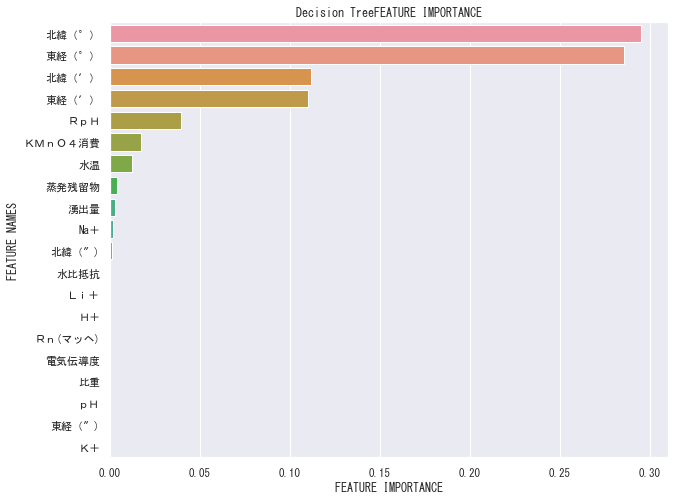

In [48]:
plot_feature_importance(clf_tree.feature_importances_, x_train.columns, 'Decision Tree', show_num=20)

In [49]:
target_names = ce_oe.category_mapping[0]['mapping']
target_names = np.asarray(target_names.keys()[y_test-1])
target_names

array(['長崎県', '佐賀県', '鹿児島県', ..., '佐賀県', '長崎県', '福岡県'], dtype=object)

In [50]:
from dtreeplt import dtreeplt
dtree = dtreeplt(model=clf_tree,
                 feature_names=x_test.columns,
                target_names=target_names)

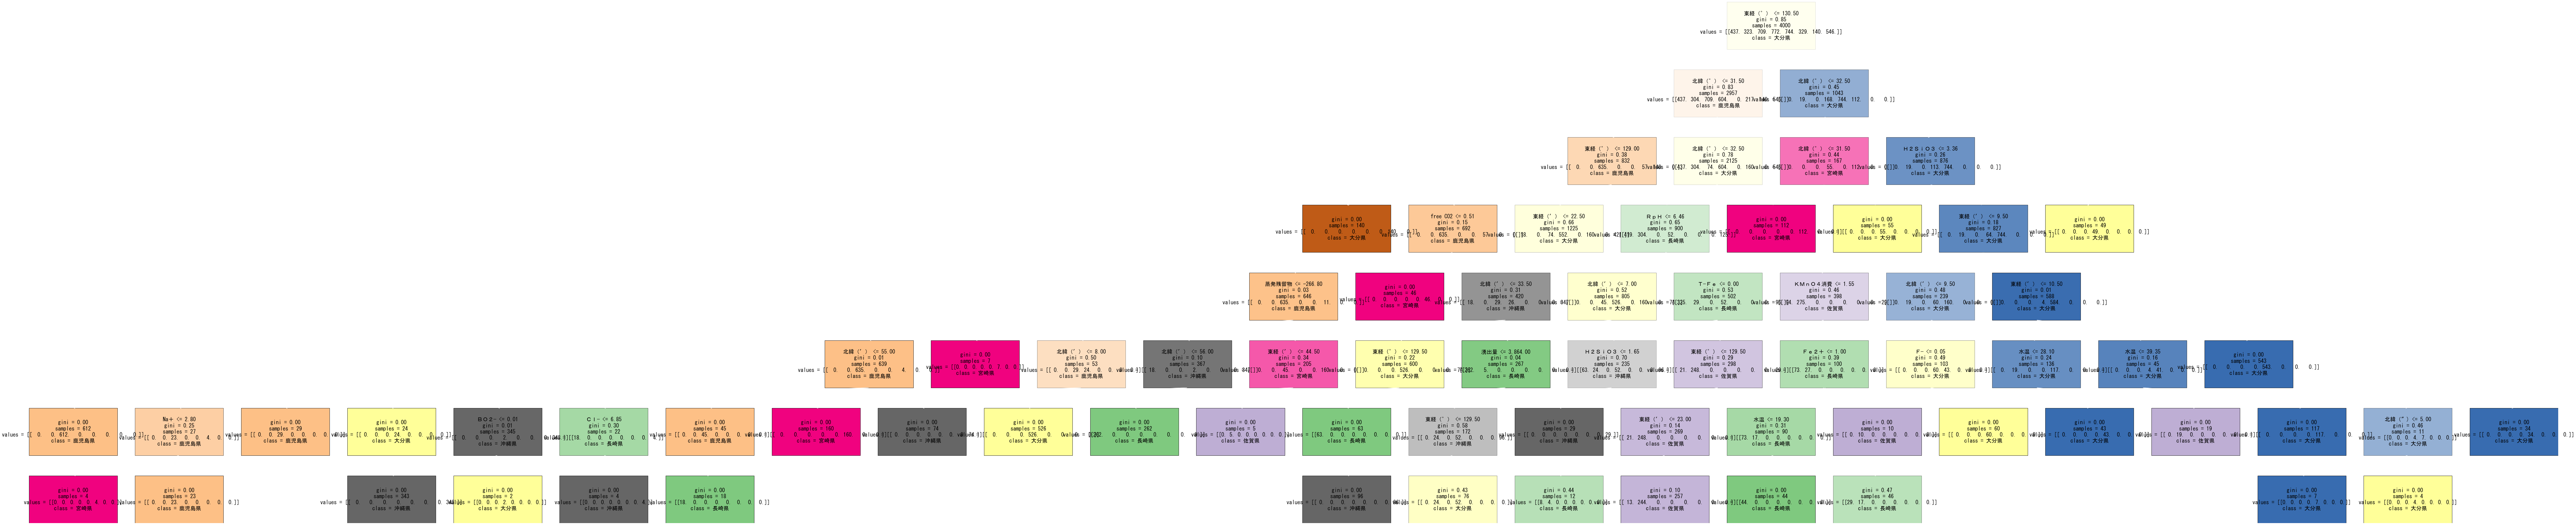

In [51]:
fig = dtree.view()

In [52]:
fig.savefig('tree.png', dpi=150, quality=100)